# Training an RCNN model on a custom dataset

## Importing necessary libraries

In [8]:
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image, ExifTags
import xml.etree.ElementTree as ET
import numpy as np

## 2.1 Creating Custom Dataset Class
The reference scripts for training object detection, instance segmentation and person keypoint detection allows for easily supporting adding new custom datasets. The dataset should inherit from the standard torch.utils.data.Dataset class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return a tuple:

- image:   `torchvision.tv_tensors.Image` of shape `[3, H, W]`, a pure tensor, or a PIL Image of size `(H, W)`


- target: a dict containing the following fields


    * `boxes`, `torchvision.tv_tensors.BoundingBoxes` of shape `[N, 4]`: the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`


    * `labels`, `integer torch.Tensor` of shape `[N]`: the label for each bounding box. `0` represents always the background class.  


    * `image_id`, int: an image identifier. It should be unique between all the images in the dataset, and is used during evaluation  


    * `area`, float `torch.Tensor` of shape `[N]`: the area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.


    * `iscrowd`, uint8 `torch.Tensor` of shape `[N]`: instances with iscrowd=True will be ignored during evaluation.

    
    * (optionally) `masks`, `torchvision.tv_tensors.Mask` of shape `[N, H, W]`: the segmentation masks for each one of the objects

[source](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)


### Errors Encountered:
`AssertionError: Results do not correspond to current coco set - wrong types and sizes`

Solution: Just change the line `target["image_id"] = torch.tensor([index])` to `target["image_id"] = index`

[source](https://stackoverflow.com/questions/76798069/assertionerror-results-do-not-correspond-to-current-coco-set-wrong-types-and)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (str): Root directory containing the 'power_bank' and 'spec_case' folders.
            transforms (callable, optional): A function/transform to apply to the images.
        """
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_paths = []
        self.annotation_paths = []
        self.box_dims = []  # Initialize box_dims to store widths and heights of bounding boxes
        
        # Collect all images and their corresponding XML files
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith(".jpg") or file.endswith(".png"):
                        self.image_paths.append(os.path.join(class_path, file))
                        self.annotation_paths.append(
                            os.path.join(class_path, file.replace(".jpg", ".xml").replace(".png", ".xml"))
                        )

    def __len__(self):
        return len(self.image_paths)
    

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        area = []
        iscrowd = []

        #Fiinding resolution for rotation
        res = root.find("size")
        xres = int(res.find("width").text)
        yres = int(res.find("height").text)
        
        for obj in root.findall("object"):
            name = obj.find("name").text
            label = 1 if name == "power_bank" else 2  # Assign class labels
            labels.append(label)
            
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)

            #Testing
            #xmin, ymin, xmax, ymax = ymin, xmax, ymax, xmin
            #ymin, ymax = ymax, ymin
            
            boxes.append([xmin, ymin, xmax, ymax])

            #Testing, Delete after testing
            # print('-'*5, "Inside Class", '-'*5)
            # print("xmin = ", xmin)
            # print("ymin = ", ymin)
            # print("xmax = ", xmax)
            # print("ymax = ", ymax)
            # print(annotation_path)
            



            area.append((xmax - xmin) * (ymax - ymin))
            iscrowd.append(0)  # Assuming no crowd instances

        return {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "area": torch.tensor(area, dtype=torch.float32),
            "iscrowd": torch.tensor(iscrowd, dtype=torch.uint8),
            "img_resolution" : (xres, yres)
        }

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        annotation_path = self.annotation_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        #Testing
        #img = img.rotate(270, expand=True)
        #img = img.transpose(Image.FLIP_LEFT_RIGHT)

        # Parse annotation
        target = self.parse_annotation(annotation_path)
        # target["image_id"] = torch.tensor([idx])
        target["image_id"] = idx

        img_res = target.pop("img_resolution")

        """
        If the image is :
        
        <width>1920</width>
		<height>1440</height>
        then no rotation.

        But if the image is:

        <width>1440</width>
		<height>1920</height>
        then rotate 270 degrees 
        """     
        if img_res == (1440, 1920):
            img = img.rotate(270, expand=True)


        # Apply transforms
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

## 2.2 Testing the dataset

This section is entirely optional. We just print some images and their corresponding bounding boxes using our custom dataset class. Remember to correctly set the directory of the dataset.

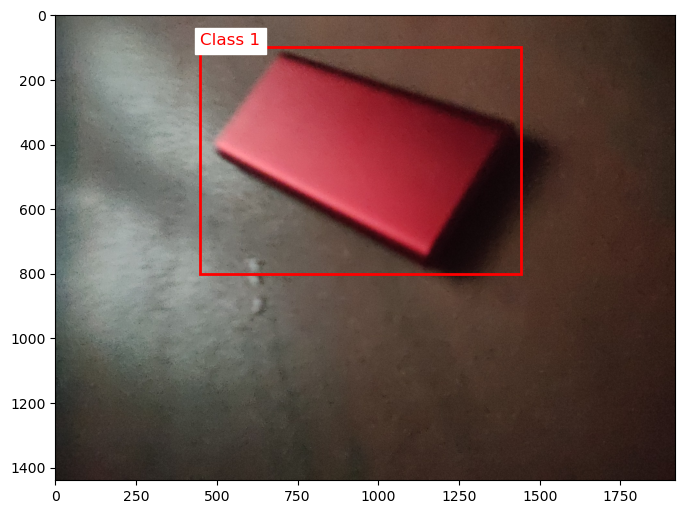

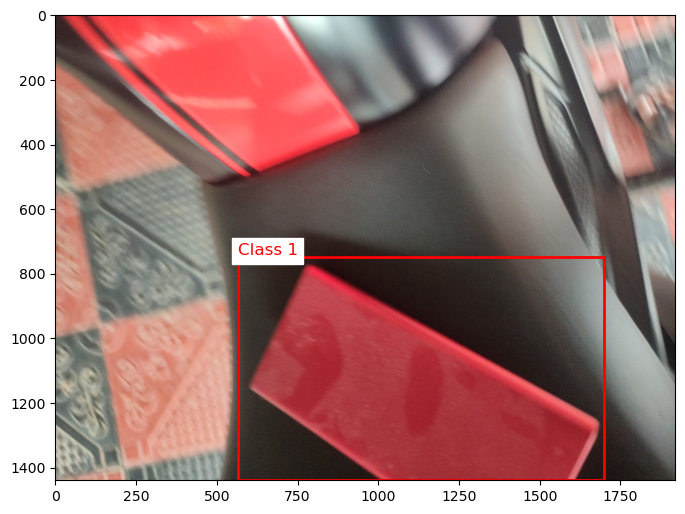

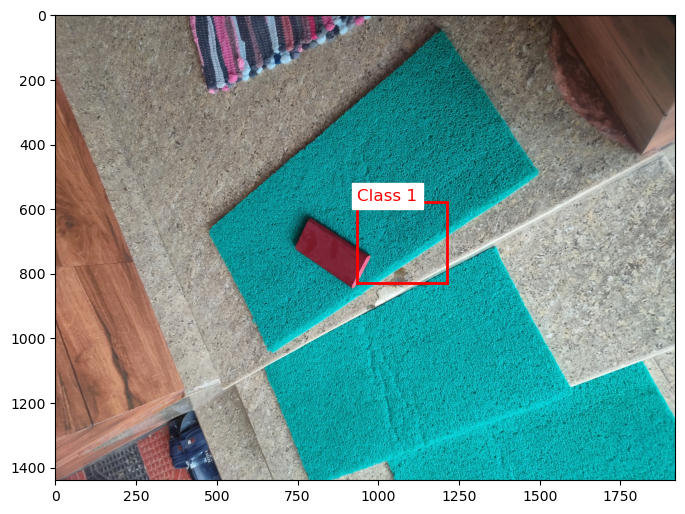

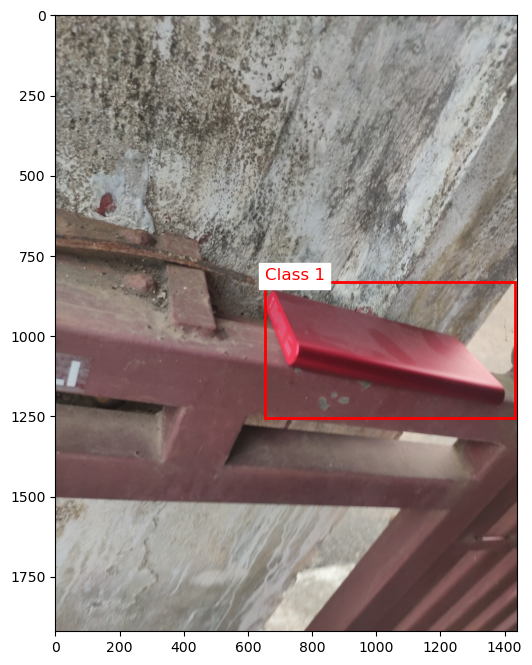

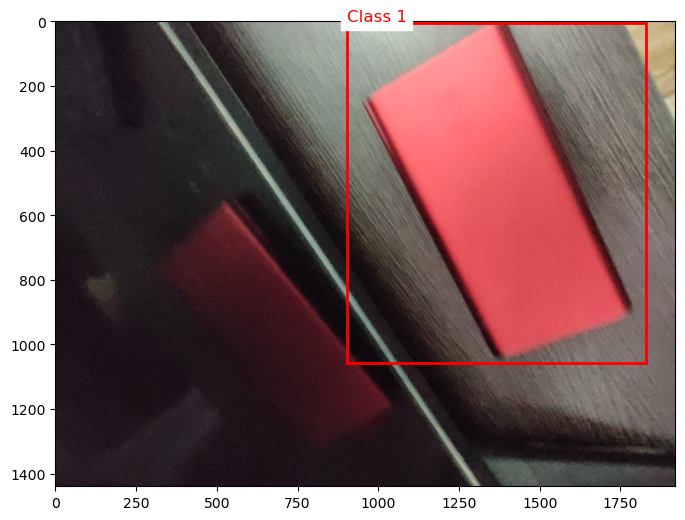

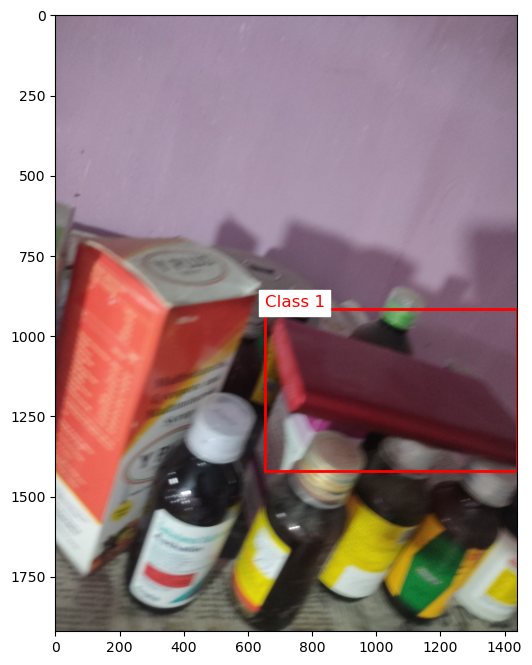

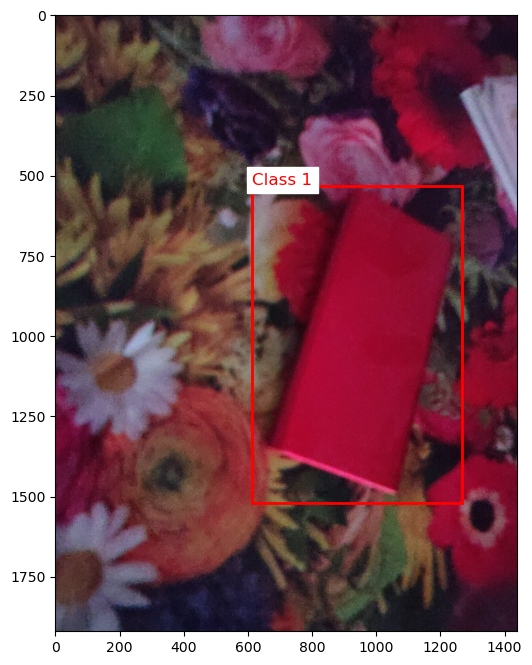

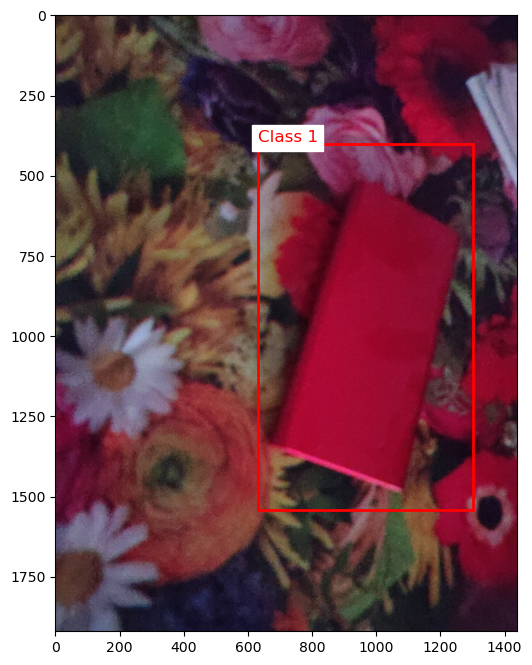

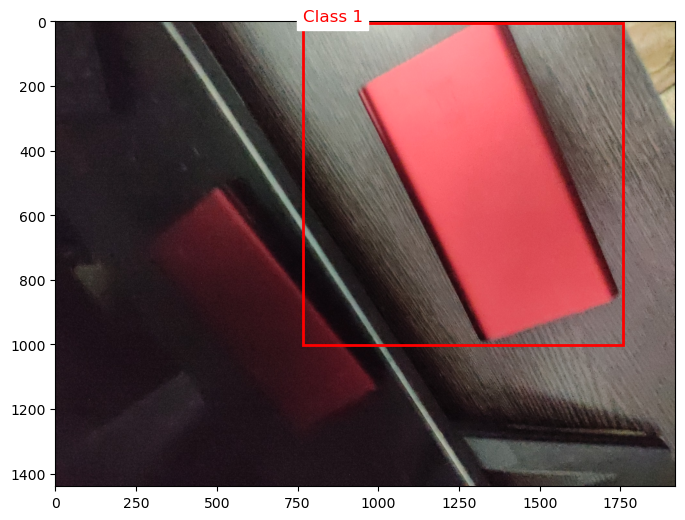

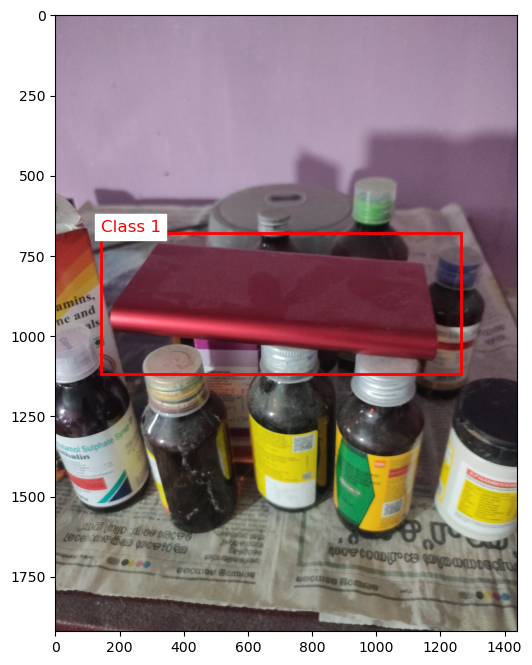

In [10]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

def visualize_dataset(dataset, num_images=5):
    """
    Visualize a few images from the dataset with their bounding boxes.

    Args:
        dataset (Dataset): The dataset object.
        num_images (int): Number of images to visualize.
    """
    for i in range(num_images):
        # Get image and target from the dataset
        img, target = dataset[150 + i]
        
        # Convert image tensor to PIL Image if needed
        if isinstance(img, torch.Tensor):
            img = to_pil_image(img)
        
        # Create a Matplotlib figure
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(img, origin="upper")
        
        # Add bounding boxes to the image
        boxes = target["boxes"]
        labels = target["labels"]
        for box, label in zip(boxes, labels):
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin), width, height,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"Class {label.item()}", 
                    color='red', fontsize=12, backgroundcolor='white')
        
        #ax.axis("off")
        plt.show()


dataset = CustomDataset(root_dir="/home/adarshh/For Github/RCNN/custom_sample_dataset")
visualize_dataset(dataset, 10)

## 2.3 Finetuning from a pretrained model

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 3  # 2 class (spectacle case and power bank) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_faster_rcnn(num_classes):
    # Load a pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Get the number of input features for the box classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the box predictor with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

## 2.4 Installing helper functions

In [13]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2025-02-04 21:26:56--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.1’

     0K ...                                                   100% 39.3M=0s

2025-02-04 21:26:57 (39.3 MB/s) - ‘engine.py.1’ saved [4063/4063]

--2025-02-04 21:26:57--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

0

## 2.5 Helper functions for data augmentation / transformation

In [14]:
from torchvision.transforms import v2


def get_transform(train):
    transforms = []
    if train:
        #transforms.append(v2.RandomHorizontalFlip(0.5))
        pass    #Randomly flipping throws of the bounding box locations
    # transforms.append(v2.ToDtype(torch.float, scale=True))
    # transforms.append(v2.ToPureTensor())
    transforms.append(T.ToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    # transforms.append(T.ToPILImage())  # Converts PIL to Tensor (New alternative to ToTensor())
    # transforms.append(T.ToDtype(torch.float, scale=True))   # Ensures dtype conversion

    return T.Compose(transforms)

## 2.6 Testing `forward()` method (Optional)

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.

In [15]:
import utils
from torchvision import transforms

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights = "DEFAULT")

dataset = CustomDataset('/home/adarshh/For Github/RCNN/custom_sample_dataset', get_transform(train=True))

#Only for debugging
# img, target = dataset[0]
# print(type(img))

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]   #Shallow Copying: The operation ensures each target dictionary is reconstructed, preventing unintended side effects when modifying targets.
output = model(images, targets)  # Returns losses and detections
print(output)

{'loss_classifier': tensor(0.4359, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1242, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0359, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0023, grad_fn=<DivBackward0>)}


## 2.7 Main function that performs the training

In [16]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has three classes - power_bank, spec_case and background
num_classes = 3

# use our dataset and defined transformations
dataset = CustomDataset('/home/adarshh/For Github/RCNN/custom_sample_dataset', get_transform(train=True))
dataset_test = CustomDataset('/home/adarshh/For Github/RCNN/custom_sample_dataset', get_transform(train=False))

"""Stratified Split

We need to ensure that both classes appear in the training and test sets. Since you have:

    131 power bank images
    130 spec case images

We should keep the 80:20 ratio within each class:

    Power bank: 131x0.8=104 (train), 131x0.2=27 (test)
    Spec case: 130x0.8=104 (train), 130x0.2=26 (test)"""

# Separate indices for power bank and spec case images
power_bank_indices = list(range(131))  # First 131 are power banks
spec_case_indices = list(range(131, 261))  # Next 130 are spec cases

# Shuffle the indices
import random
random.shuffle(power_bank_indices)
random.shuffle(spec_case_indices)

# 80% train, 20% test split
train_indices = power_bank_indices[:104] + spec_case_indices[:104]
test_indices = power_bank_indices[104:] + spec_case_indices[104:]

# Create subsets
dataset = torch.utils.data.Subset(dataset, train_indices)
dataset_test = torch.utils.data.Subset(dataset_test, test_indices)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=utils.collate_fn
)


data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_faster_rcnn(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

best_model_params_path = '/home/adarshh/For Github/RCNN/best_model.pt'
torch.save(model.state_dict(), best_model_params_path)


/home/adarshh/ml/tf_gpu/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/52]  eta: 0:01:36  lr: 0.000103  loss: 1.2717 (1.2717)  loss_classifier: 1.1246 (1.1246)  loss_box_reg: 0.1410 (0.1410)  loss_objectness: 0.0038 (0.0038)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 1.8629  data: 0.1853  max mem: 4758
Epoch: [0]  [10/52]  eta: 0:00:44  lr: 0.001082  loss: 0.7149 (0.7911)  loss_classifier: 0.5387 (0.6310)  loss_box_reg: 0.1601 (0.1511)  loss_objectness: 0.0038 (0.0066)  loss_rpn_box_reg: 0.0023 (0.0024)  time: 1.0504  data: 0.1672  max mem: 4915
Epoch: [0]  [20/52]  eta: 0:00:32  lr: 0.002062  loss: 0.3871 (0.6018)  loss_classifier: 0.2380 (0.4441)  loss_box_reg: 0.1482 (0.1481)  loss_objectness: 0.0037 (0.0067)  loss_rpn_box_reg: 0.0025 (0.0028)  time: 0.9583  data: 0.1534  max mem: 4915
Epoch: [0]  [30/52]  eta: 0:00:21  lr: 0.003041  loss: 0.3198 (0.4995)  loss_classifier: 0.1847 (0.3396)  loss_box_reg: 0.1398 (0.1468)  loss_objectness: 0.0117 (0.0103)  loss_rpn_box_reg: 0.0025 (0.0028)  time: 0.9353  data: 0.1426  max mem: 4915
Epoch: [

## 2.8 Testing on Droidcam

In [ ]:
#Loading already trained model
num_classes = 3
from torchvision.models.detection import fasterrcnn_resnet50_fpn
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
best_model_params_path = '/home/adarshh/For Github/RCNN/best_model.pt'
model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)  # Move model to device

import cv2
import torch
import numpy as np
import time
import threading
from torchvision.transforms import functional as F

def capture_frames(cap):
    global frame
    while True:
        ret, new_frame = cap.read()
        if ret:
            frame = new_frame  # Always update to the latest frame

def live_object_detection(model, device, droidcam_url, score_threshold=0.8):
    """
    Captures live feed from DroidCam and performs real-time object detection with FPS display.

    Args:
        model (torch.nn.Module): The trained Faster R-CNN model.
        device (torch.device): CUDA or CPU device.
        droidcam_url (str): The URL of the DroidCam feed (e.g., "http://192.168.1.2:4747/video").
        score_threshold (float): Minimum confidence score to display a bounding box.
    """

    global frame
    cap = cv2.VideoCapture(droidcam_url)
    cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)  # Reduce buffer size
    
    if not cap.isOpened():
        print("Error: Could not open DroidCam feed. Check the URL.")
        return
    
    # Start a separate thread for frame capture
    threading.Thread(target=capture_frames, args=(cap,), daemon=True).start()
    
    model.eval()  # Set model to evaluation mode
    prev_time = time.time()

    while True:
        if frame is None:
            continue  # Wait until frame is available
        
        # Calculate FPS
        curr_time = time.time()
        fps = 1 / (curr_time - prev_time)
        prev_time = curr_time

        # Convert frame from BGR (OpenCV) to RGB (for PyTorch)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = F.to_tensor(rgb_frame).unsqueeze(0).to(device)

        # Get predictions
        with torch.no_grad():
            prediction = model(img_tensor)[0]

        # Extract boxes, labels, and scores
        pred_boxes = prediction["boxes"].cpu().numpy()
        pred_labels = prediction["labels"].cpu().numpy()
        pred_scores = prediction["scores"].cpu().numpy()

        # Draw bounding boxes on the frame
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            if score >= score_threshold:
                xmin, ymin, xmax, ymax = map(int, box)
                cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                cv2.putText(frame, f"Class {label} ({score:.2f})", 
                            (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, (0, 255, 0), 2)

        # Display FPS on the frame
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Display the frame with bounding boxes
        cv2.imshow("Live Object Detection", frame)

        # Break on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


# Example usage:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
droidcam_url = "http://XXX.XXX.X.XX:4747/video"     # Change this to your DroidCam IP
frame = None  # Initialize global frame variable
live_object_detection(model, device, droidcam_url)

: 